# **Ансамбли моделей машинного обучения.**

**Цель лабораторной работы:** изучение ансамблей моделей машинного обучения.

**Задание:**
- Выберите набор данных (датасет) для решения задачи классификации или регресии.

- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

- С использованием метода train_test_split разделите выборку на обучающую и тестовую.

- Обучите следующие ансамблевые модели:

  - одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
  - одну из моделей группы бустинга;
  - одну из моделей группы стекинга.
- (+1 балл на экзамене) Дополнительно к указанным моделям обучите еще две модели:
   - Модель многослойного персептрона. По желанию, вместо библиотеки  - scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.

  - Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.
- Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

Идея использования ансамблевых моделей состоит в том, что оценивается результат совместного голосования различных моделей. Варианты объединения моделей в ансамбль могут быть различными и могут использоваться для решения различных задач.

В ансамблевых моделях часто используют такие термины как "сильный ученик" или "сильная модель" (strong learner) и "слабый ученик" или "слабая модель" (weak learner). На основе набора "слабых моделей" строится ансамбль, который является "сильной моделью".

Вспомним, что в соответствии с дилеммой смещения–дисперсии невозможно одновременно улучшить и смещение и дисперсию модели. Поэтому некоторые ансамблевые классификаторы ориентированы на уменьшение дисперсии, а некоторые на уменьшение смещения.

### **Импорт библиотек и загрузка датасета**
Импортируем библиотеки с помощью команды import.

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.ticker as ticker
import math
from enum import Enum
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, fbeta_score, mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [49]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [50]:
filename = '../datasets/water_potability.csv'
data = pd.read_csv(filename)

### **Очистка датасета**

Основываясь на том, что мы делали выше, обработаем все остальные столбцы и таким образом полностью почистим набор

In [51]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [52]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [53]:
# проверим пропущенные значения
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [54]:
strategies=['mean', 'median', 'most_frequent']

In [55]:
# импьютация нужной колонки с помощью нужной стратегии
def func_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    return data_num_imp

In [56]:
# замена медианой pH
col_imp = func_impute_col(data, 'ph', strategies[1])
data[['ph']] = col_imp

In [57]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Sulfate', strategies[1])
data[['Sulfate']] = col_imp

In [58]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Trihalomethanes', strategies[1])
data[['Trihalomethanes']] = col_imp

In [59]:
# проверим пропущенные значения
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### **Разделение выборки на обучающую и тестовую**

In [60]:
# целевой признак - Potability - указывает, безопасна ли вода для потребления человеком 
target = data['Potability']

In [61]:
data.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075760,-0.082004,-0.031741,0.014178,0.017466,0.040240,0.003145,-0.036107,-0.003014
Hardness,0.075760,1.000000,-0.046899,-0.030054,-0.092833,-0.023915,0.003610,-0.012707,-0.014449,-0.013837
Solids,-0.082004,-0.046899,1.000000,-0.070148,-0.149747,0.013831,0.010242,-0.008799,0.019546,0.033743
Chloramines,-0.031741,-0.030054,-0.070148,1.000000,0.023762,-0.020486,-0.012653,0.016614,0.002363,0.023779
Sulfate,0.014178,-0.092833,-0.149747,0.023762,1.000000,-0.014182,0.027102,-0.025657,-0.009767,-0.020476
Conductivity,0.017466,-0.023915,0.013831,-0.020486,-0.014182,1.000000,0.020966,0.001184,0.005798,-0.008128
Organic_carbon,0.040240,0.003610,0.010242,-0.012653,0.027102,0.020966,1.000000,-0.012958,-0.027308,-0.030001
Trihalomethanes,0.003145,-0.012707,-0.008799,0.016614,-0.025657,0.001184,-0.012958,1.000000,-0.021487,0.006887
Turbidity,-0.036107,-0.014449,0.019546,0.002363,-0.009767,0.005798,-0.027308,-0.021487,1.000000,0.001581
Potability,-0.003014,-0.013837,0.033743,0.023779,-0.020476,-0.008128,-0.030001,0.006887,0.001581,1.000000


In [62]:
# уберем столбцы, слабо коррелирующие с целевым признаком
data_clean = data
data_clean = data_clean.drop(columns = ['ph'], axis = 1)
data_clean = data_clean.drop(columns = ['Conductivity'], axis = 1)
data_clean = data_clean.drop(columns = ['Trihalomethanes'], axis = 1)
data_clean = data_clean.drop(columns = ['Turbidity'], axis = 1)
data_clean = data_clean.drop(columns = ['Hardness'], axis = 1)
data_clean2 = data_clean.drop(columns = ['Potability'], axis = 1)

In [63]:
x_train,x_test,y_train,y_test=train_test_split(data_clean2,target,test_size=0.2,random_state=1)

In [64]:
data_clean2_np = data_clean2.to_numpy()
target_np = target.to_numpy()

In [65]:
data_clean2.corr()

,Solids,Chloramines,Sulfate,Organic_carbon
Solids,1.000000,-0.070148,-0.149747,0.010242
Chloramines,-0.070148,1.000000,0.023762,-0.012653
Sulfate,-0.149747,0.023762,1.000000,0.027102
Organic_carbon,0.010242,-0.012653,0.027102,1.000000


In [66]:
feature_names = ['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon']

## **Обучение моделей**

### **Бэгинг**

Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на которую ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными (что характерно для решающего дерева), и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

Важно то что модель бэггинга строится на ансамбле разных обучающих выборок, но одинаковых моделей.

**Out-of-bag error** \
В бэггинге и моделях на основе бэггинга (в том числе, в модели случайного леса) нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.

Это можно легко доказать: пусть в выборке N объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект попадают в подвыборку с вероятностью 1N. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли N раз): (1−1N)N. При N стремящемся к бесконечности получаем второй "замечательный" предел, значение которого 1e. Тогда вероятность попадания конкретного объекта в подвыборку приближенно равна 1−1e что составляет около 63%.

Таким образом, примерно 100%-63%=37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева. Такие объекты могут быть использованы в качестве тестовой выборки.

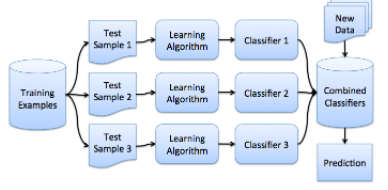

In [67]:
# Обучим классификатор на 5 деревьях
bc1 = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc1.fit(data_clean2, target)

c:\Users\Pocht\OneDrive\Study\6 семестр\ТМО (Гапанюк)\ML-Technologies\env\lib\site-packages\sklearn\ensemble\_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\Pocht\OneDrive\Study\6 семестр\ТМО (Гапанюк)\ML-Technologies\env\lib\site-packages\sklearn\ensemble\_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)

In [68]:
# Какие объекты были использованы в обучающей выборке каждого дерева
bc1.estimators_samples_

[array([1445, 1457,  910, ..., 1314, 2822, 3157]),
 array([ 814, 2530, 1770, ..., 1418,  834, 2685]),
 array([1433, 1846, 2043, ..., 2811, 1614, 3037]),
 array([ 916, 1128, 2646, ..., 3263, 2679, 1308]),
 array([ 656, 1806, 1969, ...,  509,  655,  745])]

In [69]:
# Сконвертируем эти данные в двоичную матрицу, 
# 1 соответствует элементам, попавшим в обучающую выборку
bin_array = np.zeros((5, data_clean2.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 1.]])

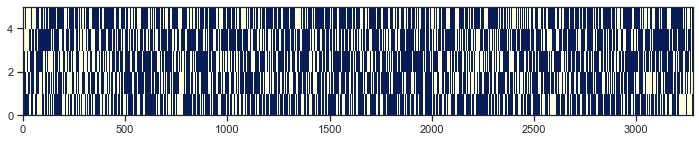

In [70]:
# И визуализируем (синим цветом показаны данные, которые попали в обучающую выборку)
fig, ax = plt.subplots(figsize=(12,2))
ax.pcolor(bin_array, cmap='YlGnBu')
plt.show()

In [71]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 35.870000000000005%
Для модели № 2 размер OOB составляет 36.39%
Для модели № 3 размер OOB составляет 37.480000000000004%
Для модели № 4 размер OOB составляет 36.870000000000005%
Для модели № 5 размер OOB составляет 36.08%


In [72]:
# Out-of-bag error, возвращаемый классификатором
# Для классификации используется метрика accuracy
bc1.oob_score_

0.5647130647130647

### **Бустинг**

Изначально метод бустинга (от hypothesis boosting - усиление гипотезы) - это любой ансамблевый метод, который способен комбинировать несколько "слабых моделей" в одну "сильную модель".

Сейчас термин "бустинг", как правило, ассоциируется с алгоритмом градиентного бустинга.

В отличие от методов бэггинга и случайного леса, которые ориентированы прежде всего на минимизизацию дисперсии (Variance), методы бустинга ориентированы прежде всего на минимизацию смещения (Bias) и, отчасти, на минимизизацию дисперсии.

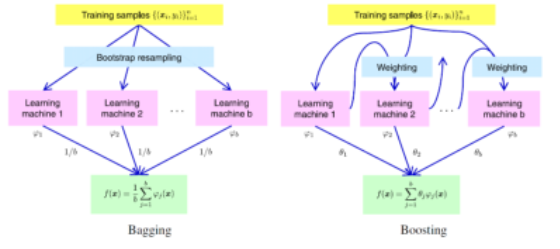

AdaBoost (сокращение от Adaptive Boosting) — алгоритм машинного обучения,  может использоваться в сочетании с несколькими алгоритмами классификации для улучшения их эффективности. Алгоритм усиливает классификаторы, объединяя их в «комитет» (ансамбль). AdaBoost является адаптивным в том смысле, что каждый следующий комитет классификаторов строится по объектам, неверно классифицированным предыдущими комитетами. AdaBoost чувствителен к шуму в данных и выбросам. Однако он менее подвержен переобучению по сравнению с другими алгоритмами машинного обучения.

В библиотеке scikit-learn реализован многоклассовый вариант алгоритма AdaBoost - алгоритм SAMME. (Stagewise Additive Modeling using a Multiclass Exponential loss function - ступенчатое аддитивное моделирование с применением многоклассовой экспоненциальной функции потерь). Модификация этого алгоритма, которая предсказывает не только классы, но и вероятности классов называется "SAMME.R".

In [73]:
# Обучим классификатор на 5 деревьях
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(data_clean2, target)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

In [74]:
ab1.estimator_weights_

array([0.4997704 , 0.0618242 , 0.07746025, 0.09632301, 0.07318864])

In [75]:
ab1.score(data_clean2, target)

0.6224053724053724

### **Стекинг**

Во всех ансамблевых моделях явно или неявно используется модель верхнего уровня. В стекинге для такой модели используется явное название мета-ученик (meta-learner) или модель 2 уровня (level 2 model).

В моделях на основе бэггинга (бэггинг, случайный лес, сверхслучайные деревья) в качестве модели 2 уровня используется усреднение результатов голосования моделей.

В моделях на основе бустинга используется взвешенная сумма результатов голосования моделей. Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".

Стекинг принципиальноо отличается от моделей на основе бэггинга и бустинга следующим:

- Мета-ученик является отдельной моделью машинного обучения, выходы "слабых моделей" рассматриваются как входные признаки для мета-ученика.

- В качестве "слабых моделей" рассматриваются различные модели, которые дают различные результаты. (Напомним, что в бэггинге использовались различные выборки, но одинаковая модель). Эти результаты рассматриваются как входные признаки для мета-ученика.

Модели 1 уровня обычно сложные и использующие различные алгоритмы, например SVM, дерево решений, случайный лес и т.д. Использование различных алгоритмов, фактически, обеспечивает дисперсию внутри модели, а также исключает возможность возникновения линейной зависимости между признаками, поступающими на вход модели 2 уровня.

Модели 2 уровня обычно простые. Часто используются линейные модели. Например для задачи регрессии - линейная регрессия, для задачи классификации - логистическая регрессия.

In [76]:
results = []
result_labels = ['LR', 'Tree', 'RF', 'Boost', 'Bagg', 'Tree+RF->LR', 'Tree+RF->RF', 'Tree+RF+LR->LR', 'Tree+RF+LR->RF', 'Tree+RF+LR->Tree']

In [77]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result = mean_absolute_error(y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))
    return result

In [78]:
# Точность на отдельных моделях
for model in [
    LogisticRegression(random_state=1),
    DecisionTreeClassifier(random_state=1),
    RandomForestClassifier(n_estimators=5, random_state=1),
    AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=1),
    BaggingClassifier(n_estimators=5, oob_score=True, random_state=1)
]:
    results.append(val_mae(model))
    print('==========================')
    print()

LogisticRegression(random_state=1)
MAE=0.4298780487804878

DecisionTreeClassifier(random_state=1)
MAE=0.47865853658536583

RandomForestClassifier(n_estimators=5, random_state=1)
MAE=0.45884146341463417

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=1)
MAE=0.42378048780487804

BaggingClassifier(n_estimators=5, oob_score=True, random_state=1)
MAE=0.45426829268292684



c:\Users\Pocht\OneDrive\Study\6 семестр\ТМО (Гапанюк)\ML-Technologies\env\lib\site-packages\sklearn\ensemble\_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\Pocht\OneDrive\Study\6 семестр\ТМО (Гапанюк)\ML-Technologies\env\lib\site-packages\sklearn\ensemble\_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


In [79]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(x_train, y_train, x_test)

# модели первого уровня
model_tree = Classifier(dataset=dataset, estimator=DecisionTreeClassifier, name='tree')
model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 5},name='rf')
model_lr = Classifier(dataset=dataset, estimator=LogisticRegression,name='lr')

In [80]:
# Эксперимент 1
# Первый уровень - две модели: дерево решений и случайный лес
# Второй уровень: логистическая регрессия

pipeline = ModelsPipeline(model_tree, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker1 = Classifier(dataset=stack_ds, estimator=LogisticRegression)
results1 = stacker1.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.4731273332457616, 0.4719727540283309, 0.46754999389171, 0.4625838623063371, 0.4625317621569097, 0.4709491049240734, 0.45583520854415344, 0.48270576147497324, 0.47876142804204636, 0.46594172619943885]
Mean accuracy: 0.4691958934813735
Standard Deviation: 0.007617040126164968
Variance: 5.801930028360723e-05


In [81]:
results.append(0.4691958934813735)

In [82]:
# Эксперимент 2
# Первый уровень - две модели: дерево решений и случайный лес
# Второй уровень: случайный лес

stacker2 = Classifier(dataset=stack_ds, estimator=RandomForestClassifier)
results2 = stacker2.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.4704746040016729, 0.46858976001160674, 0.468057368304419, 0.46018026935961065, 0.46963184198880037, 0.46791568747282397, 0.45416318082490365, 0.4824683923884347, 0.47614372644339753, 0.4669542343712827]
Mean accuracy: 0.4684579065166952
Standard Deviation: 0.007323947314600516
Variance: 5.3640204267044104e-05


In [83]:
results.append(0.4684579065166952)

In [84]:
# Эксперимент 3
# Первый уровень - три модели: дерево, логистическая регрессия и случайный лес
# Второй уровень: логистическая регрессия
pipeline2 = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline2.stack(k=10, seed=1)
# модель второго уровня
stacker3 = Classifier(dataset=stack_ds3, estimator=LogisticRegression)
results3 = stacker3.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.47306133519440446, 0.4720450459471154, 0.4675020511287382, 0.46264976680067216, 0.4626396055021229, 0.47082421302300503, 0.4557326974595011, 0.4825692269411213, 0.47912221416956013, 0.46583224645943266]
Mean accuracy: 0.4691978402625674
Standard Deviation: 0.007644384495720454
Variance: 5.843661431841126e-05


In [85]:
results.append(0.4691978402625674)

In [86]:
# Эксперимент 4
# Первый уровень - три модели: дерево, логистическая регрессия и случайный лес
# Второй уровень: случайный лес
stacker4 = Classifier(dataset=stack_ds3, estimator=RandomForestClassifier)
results4 = stacker4.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.4723282442748092, 0.45734732824427476, 0.46106870229007635, 0.4473282442748092, 0.45530534351145036, 0.4570992366412213, 0.45151399491094146, 0.4772137404580153, 0.45595419847328245, 0.45530534351145036]
Mean accuracy: 0.459046437659033
Standard Deviation: 0.008653511777199068
Variance: 7.488326607812298e-05


In [87]:
results.append(0.459046437659033)

In [88]:
# Эксперимент 5
# Первый уровень - три модели: дерево, логистическая регрессия и случайный лес
# Второй уровень: дерево
stacker5 = Classifier(dataset=stack_ds3, estimator=DecisionTreeClassifier)
results5 = stacker5.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.48854961832061067, 0.4312977099236641, 0.46946564885496184, 0.40076335877862596, 0.5038167938931297, 0.4541984732824427, 0.4312977099236641, 0.45038167938931295, 0.46564885496183206, 0.4484732824427481]
Mean accuracy: 0.45438931297709917
Standard Deviation: 0.02820879244308864
Variance: 0.0007957359710972547


In [89]:
results.append(0.45438931297709917)

In [90]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

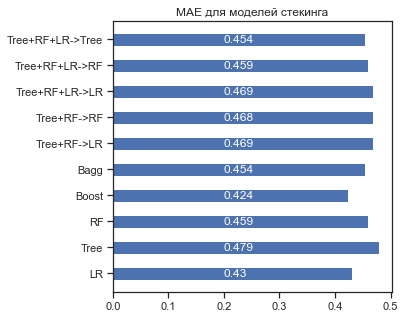

In [91]:
# Визуализация результатов
vis_models_quality(results, result_labels, 'MAE для моделей стекинга')

За счет того, что модель стекинга слабо поддается интерпертации, в основном эта модель используется тогда, когда нужно улучшить качество модели на конкретном наборе данных.